# Set all necessary libraries

In [181]:
#all necessary packages
from __future__ import print_function,division
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gp
import pylab as pl
import json
import urllib2
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels import tsa

s = json.load( open(os.getenv('PUIDATA')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load the data

In [184]:
mtaRides = np.load(os.getenv("PUIDATA")+"/MTA_Fare.npy")
mtaRides = mtaRides.astype('float') # convert value type to float so that np.nan can work
mtaRides[mtaRides == -1] = np.nan

In [185]:
#get a sense of the data
mtaRides.shape

(600, 23, 194)

In [5]:
#specify the ridetype
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [174]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations or ridetype
print (mtaRides.shape)
mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)
#or for all ride types
station_allsum = np.nansum(mtaRides, axis=1)
print (station_allsum.shape)

(600, 23, 194)
(23, 194)
(600, 194)


# Task 1 Event detection

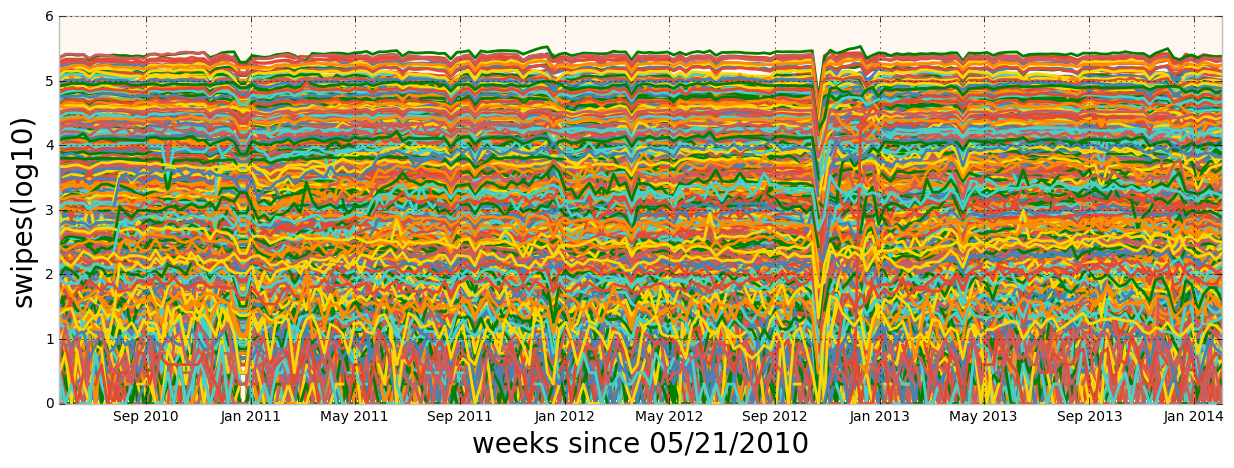

In [177]:
fig = pl.figure(7,figsize=(15,5))
ax = fig.add_subplot(111)
timerange = pd.date_range("05/21/2010","02/08/2014",freq="W")
ax.set_xlabel("weeks since 05/21/2010", fontsize=20)
ax.set_ylabel("swipes(log10)", fontsize=20)
for i in range(len(mtaRides)):
    for j in range(len(mta_allsum)):
        ax.plot(timerange,np.log10(mtaRides[i][j]))

## Figure 1: all time series for each station and each ride type

In [26]:
#sum over all stations,leaving with 23 time series, each per ridership
#transfer mta_allsum to a dataframe
ridership = pd.DataFrame(mta_allsum)
ridership = pd.DataFrame.transpose(ridership)
ridership.columns = ridetype
ridership.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,11494477,530386,47663,186413,46670,3697305,8551799,9925,333059,511894,...,122996,789972,59671,28083,-138,124555,20922,5990,220,-600
1,12526720,583394,51347,199090,64214,3981669,9486255,11708,282616,577884,...,151809,907929,69070,32194,-139,121574,21531,5981,335,-600
2,12766490,586057,51499,199531,56857,4032893,9476401,12140,301891,615400,...,151401,913987,69437,32481,-137,122044,21296,6353,328,-600
3,12653538,562465,51926,196252,37292,4032616,9449944,11084,305376,606133,...,146957,902412,67962,32267,-137,121914,21493,6453,347,-600
4,12809558,548722,51017,194747,35074,3925310,9293866,10379,335644,563310,...,137752,855437,66241,31797,40,119640,20161,6177,316,-600


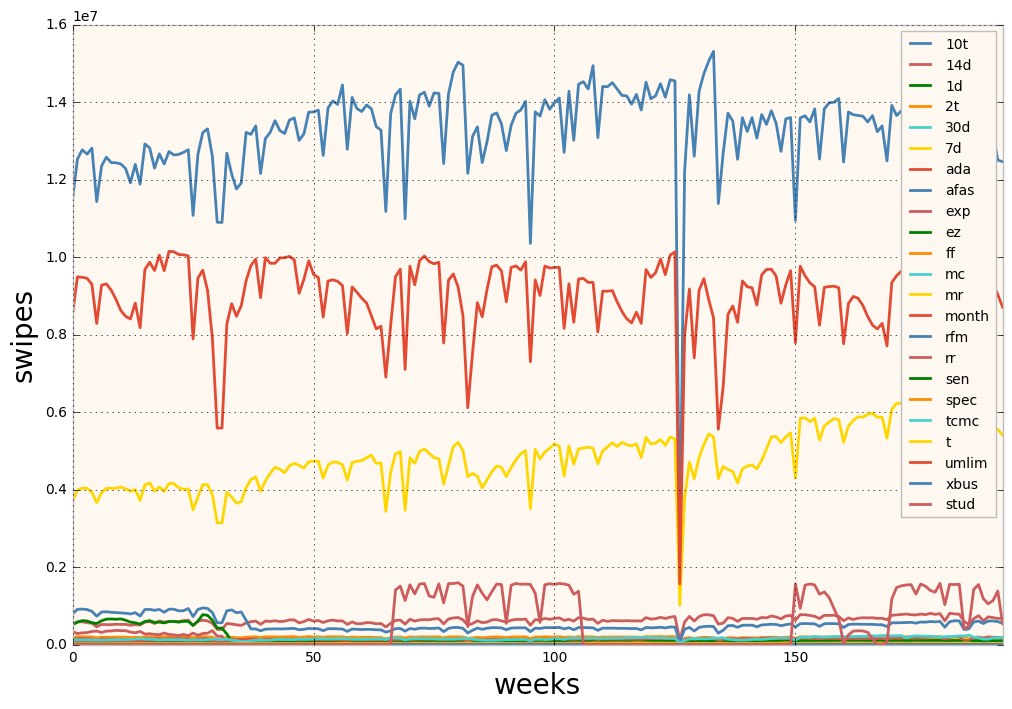

In [179]:
ridership.plot(figsize=(12,8))
pl.xlabel("weeks", fontsize=20)
pl.ylabel("swipes", fontsize=20)
pl.legend(fontsize=10)
pl.ylim(0,16000000)
plt.show()

## Figure 2: Total swipes per week for each ridership 

In [43]:
#There is a huge decrease for the 10 trips rideship:
print ("mean swipes by week for 10t {:.2f}".format(ridership['10t'].mean()))
print ("stdev swipes by week for 10t {:.2f}".format(ridership['10t'].std()))
thresholds = [ridership['10t'].mean() + 3 * ridership['10t'].std(), 
              ridership['10t'].mean() - 3 * ridership['10t'].std()]
print ("3-sigma thresholds for 10t {:.2f} {:.2f}".format(*thresholds))
#print ("earliest datapoint", min(FSNYts.index))

mean swipes by week 13242234.35
stdev swipes by week 1215646.29
3-sigma thresholds 16889173.22 9595295.49


In [44]:
ridership.loc[(ridership['10t']<thresholds[1])]

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
126,2331586,105959,10063,34760,1128,1012742,1562286,-139,-137,-139,...,2864,61852,18110,11795,8513,40017,5009,1665,-34,-140


In [45]:
#check the 14 days ridership as well for consistency:
print ("mean swipes by week for 14d {:.2f}".format(ridership['14d'].mean()))
print ("stdev swipes by week for 14d {:.2f}".format(ridership['14d'].std()))
thresholds = [ridership['14d'].mean() + 3 * ridership['14d'].std(), 
              ridership['14d'].mean() - 3 * ridership['14d'].std()]
print ("3-sigma thresholds for 10t {:.2f} {:.2f}".format(*thresholds))
#print ("earliest datapoint", min(FSNYts.index))

mean swipes by week for 14d 627772.11
stdev swipes by week for 14d 90865.14
3-sigma thresholds for 10t 900367.55 355176.68


In [46]:
ridership.loc[(ridership['14d'] < thresholds[1])]

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
126,2331586,105959,10063,34760,1128,1012742,1562286,-139,-137,-139,...,2864,61852,18110,11795,8513,40017,5009,1665,-34,-140


In [97]:
#the 127th week results in the decrease, find the time duration:
timerange[126]

Timestamp('2012-10-21 00:00:00', offset='W-SUN')

### The decrease is due to superstorm Sandy.The effect starts from 2012 Oct 26th to 2012 Oct 31th.  See the link for more details: http://web.mta.info/sandy/timeline.htm

# Task 2:
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

### To do this I first sum and average over all stations and get 23 time series, one per ridership type.
### After that I used a rolling mean for smoothing and calculate the ratio of the flux near the beginning to the flux near the end of time series.

In [189]:
mta_sumbystation = np.nansum(mtaRides, axis=0) # sum up all rides from all stations
averageBystation = np.nanmean(mtaRides, axis=0) # take average of all rides from all stations
mta_sumbycardtype = np.nansum(mtaRides, axis=1)  # sum up all rides 
                                                 # from all card types
averageBycardtype = np.nanmean(mtaRides, axis=1) # take average of all rides 
                                                 # from all card types
mta_sum = np.nansum(mta_sumbycardtype, axis=0)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [192]:
df_averagerides = pd.DataFrame()
for i in arange(len(ridetype)):
    df_averagerides[ridetype[i]] = averageBystation[i]
df_averagerides['Date'] = pd.DataFrame(timerange)

In [193]:
for i in ridetype:
    flux = (df_averagerides[i]/df_averagerides[i].sum()).rolling(window=10,center=False).mean()
    fluxRatio = flux[9] / flux[-1:]
    print ("the flux ratio beginning to end of {} is {:.3f}".format(i, float(fluxRatio.values)))

the flux ratio beginning to end of 10t is 0.977
the flux ratio beginning to end of 14d is 0.798
the flux ratio beginning to end of 1d is 0.899
the flux ratio beginning to end of 2t is 1.069
the flux ratio beginning to end of 30d is 0.966
the flux ratio beginning to end of 7d is 0.719
the flux ratio beginning to end of ada is 1.110
the flux ratio beginning to end of afas is 4768.555
the flux ratio beginning to end of exp is 93458.216
the flux ratio beginning to end of ez is 665116.357
the flux ratio beginning to end of ff is 1.220
the flux ratio beginning to end of mc is 0.823
the flux ratio beginning to end of mr is 0.000
the flux ratio beginning to end of month is 1.726
the flux ratio beginning to end of rfm is 1.537
the flux ratio beginning to end of rr is 0.385
the flux ratio beginning to end of sen is 0.343
the flux ratio beginning to end of spec is 0.014
the flux ratio beginning to end of tcmc is 0.652
the flux ratio beginning to end of t is 0.978
the flux ratio beginning to end o

## After all, type 'Sen' and 'month' show the sharpest increase and decrease respectively based on flux ratio.

# The ridership that have steadily increased

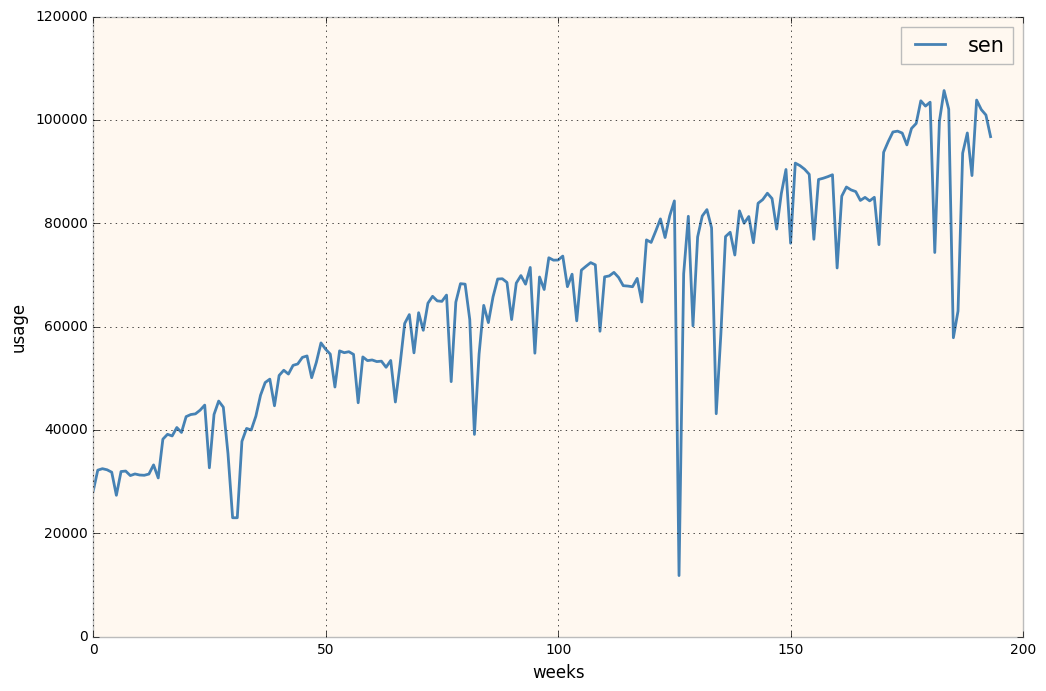

In [84]:
fig = pl.figure(7,figsize=(12,8))
ax = fig.add_subplot(111)
#ax.plot(ridership['rr'])
ax.plot(ridership['sen'])
#ax.plot(ridership['tcmc'])
ax.set_xlabel("weeks")
ax.set_ylabel("usage")
ax.legend(fontsize=15)

## Figure 3: usage of senior citizens/disabled over 194 weeks

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	S

std: 45.339
the flux ratio beginning to end of stud is 0.343
senior citizen/disabled
 0    28083
1    32194
2    32481
3    32267
4    31797
Name: sen, dtype: int64 
 189     89216
190    103823
191    101986
192    100934
193     96749
Name: sen, dtype: int64
rolling mean of senior citizen/disabled
 9     31071.4
10    31388.6
11    31289.6
12    31186.0
13    31280.6
Name: sen, dtype: float64 
 189    88627.3
190    88668.0
191    91434.5
192    91552.2
193    90660.4
Name: sen, dtype: float64


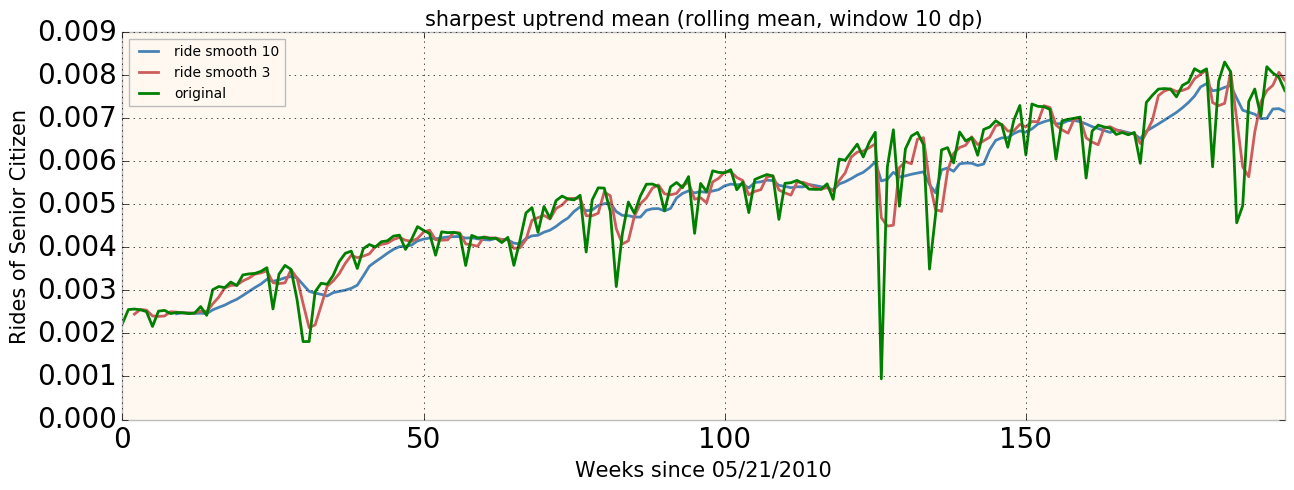

In [206]:
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(df_averagerides['sen']/df_averagerides['sen'].sum(), 10).plot(fontsize=20, label='ride smooth 10')
ax = pd.rolling_mean(df_averagerides['sen']/df_averagerides['sen'].sum(), 3).plot(fontsize=20, label='ride smooth 3')
ax.set_title("sharpest uptrend mean (rolling mean, window 10 dp)", fontsize=15)
pl.xlabel("Weeks since 05/21/2010", fontsize=15)
pl.ylabel("Rides of Senior Citizen", fontsize=15)
ax.plot(df_averagerides['sen']/df_averagerides['sen'].sum(), label="original")
pl.legend(loc='best')

flux = (df_averagerides['sen']/df_averagerides['sen'].sum()).rolling(window=10,center=False).mean()
fluxRatio = flux[9] / flux[-1:]
print ("std: {:.3f}".format(df_averagerides['sen'].std()))
print ("the flux ratio beginning to end of {} is {:.3f}".format(i, float(fluxRatio.values)))
print ("senior citizen/disabled\n", 
       ridership['sen'].dropna().head(), "\n", 
       ridership['sen'].dropna().tail())

print ("rolling mean of senior citizen/disabled\n", 
       pd.rolling_mean(ridership['sen'], 10).dropna().head(), "\n", 
       pd.rolling_mean(ridership['sen'], 10).dropna().tail())

## Figure 4 : Sharpest uptrend shown by senior citizen rideship

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()


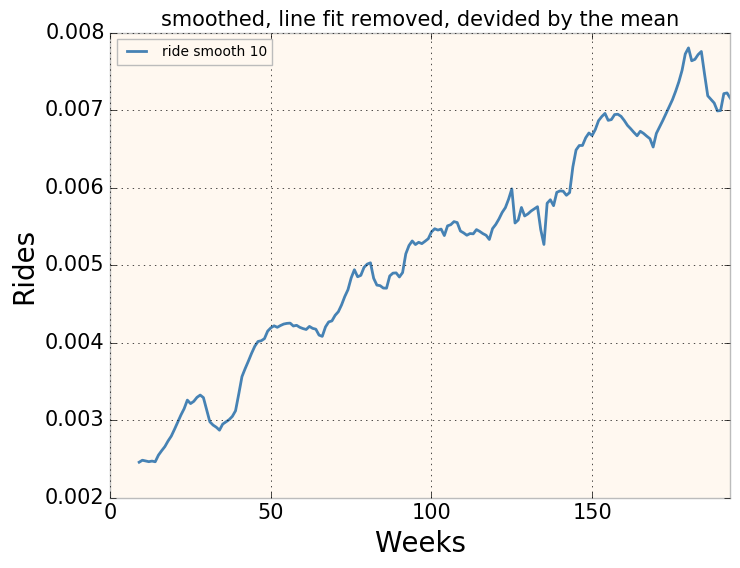

In [194]:
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(df_averagerides['sen']/df_averagerides['sen'].sum(), 10).plot(fontsize=15, label='ride smooth 10')

ax.set_title("smoothed, line fit removed, devided by the mean", fontsize=15)
pl.xlabel("Weeks", fontsize=20)
pl.ylabel("Rides", fontsize=20)
pl.legend(loc='best')

## Figure 5 : smoothed line of senior citizen ridership 

# The ridership that have steadily decreased

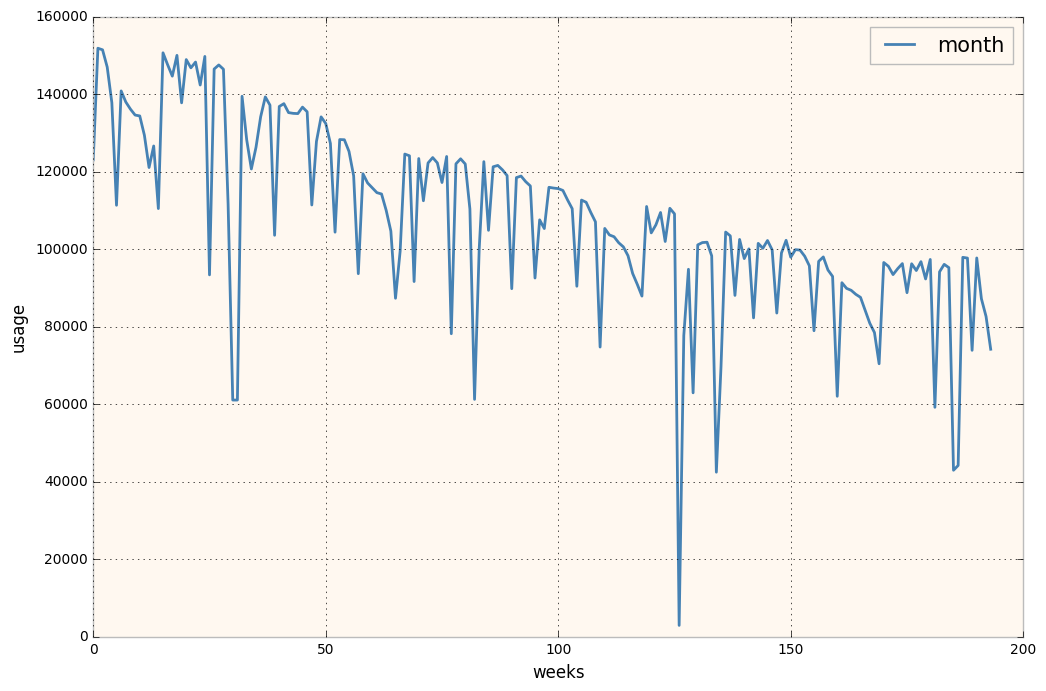

In [199]:
fig = pl.figure(7,figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(ridership['month'])
ax.set_xlabel("weeks")
ax.set_ylabel("usage")
ax.legend(fontsize=15)

## Figure 6: usage of monthly ridership over 194 weeks

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()


std: 50.950
the flux ratio beginning to end of stud is 1.726


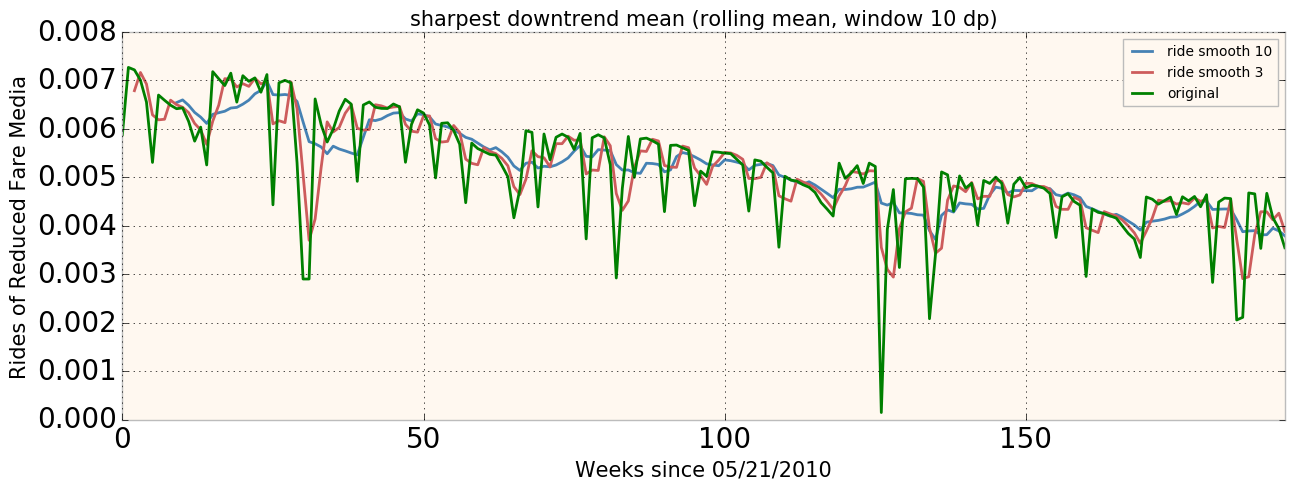

In [205]:
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(df_averagerides['month']/df_averagerides['month'].sum(), 10).plot(fontsize=20, label='ride smooth 10')
ax = pd.rolling_mean(df_averagerides['month']/df_averagerides['month'].sum(), 3).plot(fontsize=20, label='ride smooth 3')
ax.set_title("sharpest downtrend mean (rolling mean, window 10 dp)", fontsize=15)
pl.xlabel("Weeks since 05/21/2010", fontsize=15)
pl.ylabel("Rides of Reduced Fare Media", fontsize=15)
ax.plot(df_averagerides['month']/df_averagerides['month'].sum(), label="original")
pl.legend(loc='best')

flux = (df_averagerides['month']/df_averagerides['month'].sum()).rolling(window=10,center=False).mean()
fluxRatio = flux[9] / flux[-1:]
print ("std: {:.3f}".format(df_averagerides['month'].std()))
print ("the flux ratio beginning to end of {} is {:.3f}".format(i, float(fluxRatio.values)))

## Figure 7: Sharpest downtrend shown by monthly rideship

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()


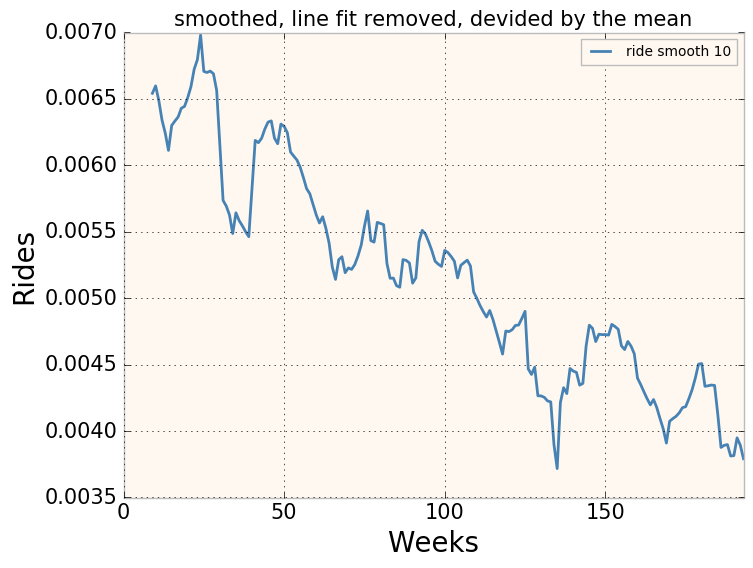

In [202]:
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(df_averagerides['month']/df_averagerides['month'].sum(), 10).plot(fontsize=15, label='ride smooth 10')

ax.set_title("smoothed, line fit removed, devided by the mean", fontsize=15)
pl.xlabel("Weeks", fontsize=20)
pl.ylabel("Rides", fontsize=20)
pl.legend(loc='best')


## Figure 8 : smoothed line of monthly ridership 

# Task 3:
## Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [133]:
station_allsum = np.nansum(mtaRides, axis=1)

In [160]:
station = pd.DataFrame(station_allsum)#,index=timerange)

In [163]:
station = pd.DataFrame.transpose(station)

In [165]:
station['weeks'] = timerange

In [166]:
station.head()

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,weeks
0,126877,37305,6605,16377,18563,19986,12448,11090,10481,147186,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,2010-05-23
1,149476,46463,6880,17407,19902,20624,13643,11658,11029,154825,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,2010-05-30
2,152382,49358,7228,17594,19947,21224,13718,12036,10880,155957,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,2010-06-06
3,160174,44848,5730,14241,16075,17411,11459,9808,9122,154913,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,2010-06-13
4,162640,41508,7031,17588,20282,20908,14093,11943,10922,157627,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,2010-06-20


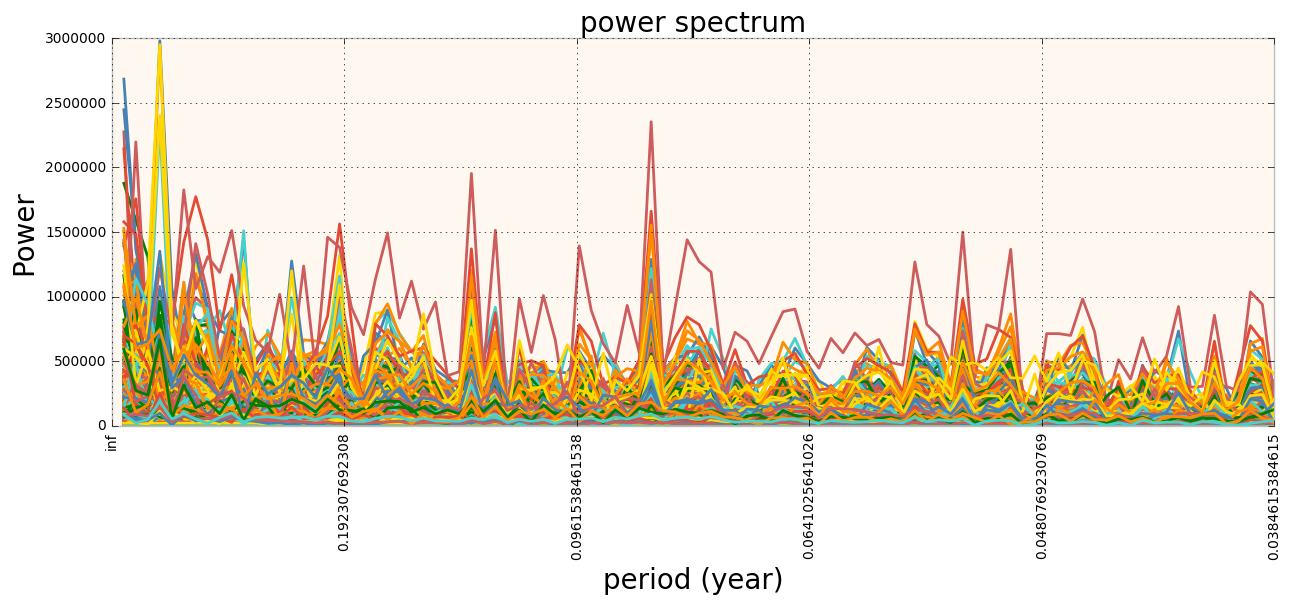

In [170]:
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)
N = len(timerange)
for i in range(600):
    f = np.abs(np.fft.rfft(station[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]))
    ax.set_xticklabels([ "%s"%(1/52./f) for f in ax.get_xticks()], rotation=90)
#print (1.0/np.fft.rfftfreq(N, 1.0)[0:2])
#print (1.0/np.fft.rfftfreq(N, 1.0)[-3:-1])
#ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=20)
pl.xlabel("period (year)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("power spectrum", fontsize=20)

## Figure 9 : Fourier Transformation of Rides over 600 subway stations

In [187]:
allperiods = [1./194, 1./104, 1./52, 1./26, 1./13, 1./8, 1./4, 1./2]

[0, 150, 194, 327]


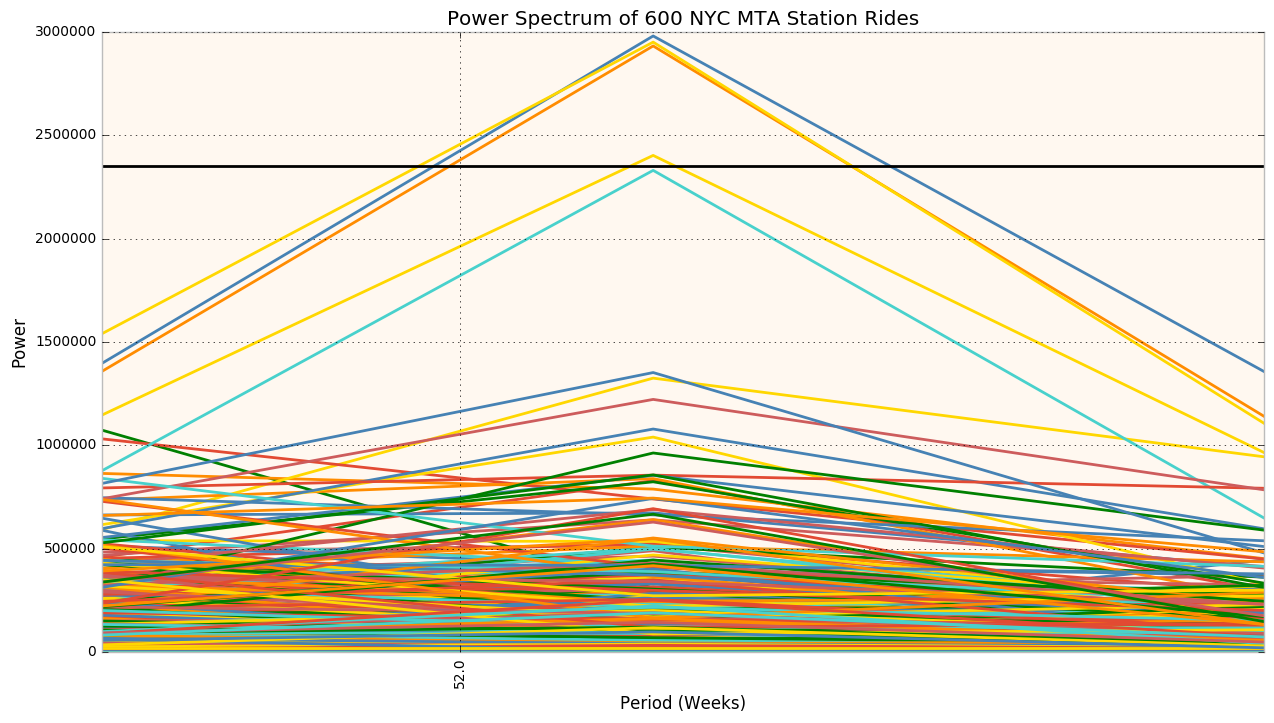

In [190]:
index = []
fig = pl.figure(figsize=(15,8))
ax = fig.add_subplot(111)
for i in range(len(mta_sumbycardtype)):
    f = np.abs(np.fft.rfft(mta_sumbycardtype[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]))
    if f[4] > 2.35e6:
        index.append(i)
ax.plot((1./60, 1./40), (2.35e6, 2.35e6), 'k-')
ax.set_xticks(allperiods)
ax.set_xticklabels([ "%s"%(1/x) for x in allperiods], rotation=90)
ax.set_xlim(1./60, 1./40)
ax.set_xlabel('Period (Weeks)')
ax.set_ylabel('Power')
ax.set_title('Power Spectrum of 600 NYC MTA Station Rides')
print (index)

## Figure 10 : zoom in figure 9 for period 52 weeks

## From figure 10, there are 4 peaks above the horizontal line.

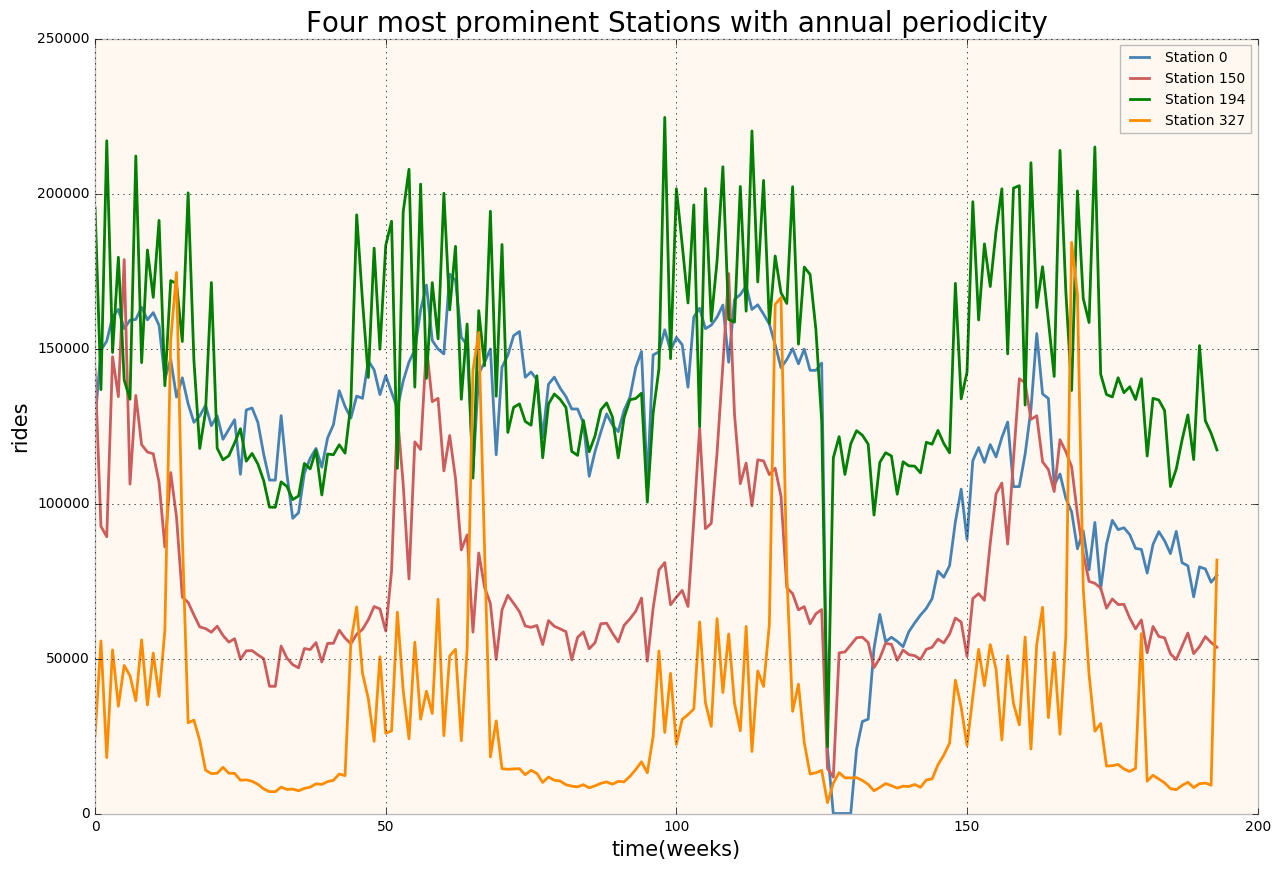

In [191]:
pl.figure(figsize=(15,10))
for i in index:
    pl.plot(mta_sumbycardtype[i], label='Station %s'%i)
pl.xlabel('time(weeks)', fontsize = 15)
pl.ylabel('rides', fontsize = 15)
pl.title('Four most prominent Stations with annual periodicity', fontsize=20)
pl.legend(loc='best')

## Figure 11 : Stations with annual periodicity

## The index of four stations are 0,150,194 and 327.